# Optimizing of Neural Network by tunning the hyperparameters

Hyperparameter optimization is a big part of deep learning. One of the most difficult problem when dealing with Neural Networks is a big set of parameters to tune. While the depth of a Neural Network is increasing, it becomes significantly hard to choose the right parameters. 

The main goal of this work is to get better performance for the Neural Network model by finding the optimal hyperparameters.

For this purpose we are going to use two tools:

1)  $\textbf{Manual Search}$

2)  $\textbf{Grid Search}$ - a model hyperparameter optimization technique from the scikit-learn library.

The initial dataset is $\textbf{MNIST}$ dataset of handwritten digits. It consists of  70000  handwritten digits, each of which comes in a square image, divided into a  28×28  pixel grid. Every pixel can take on  256  nuances of the gray color and hence each data point assumes any value in the set  {0,1,…,255} . 
Since there are 10 categories of digits, this problem represents a classification task.

$\textbf{Plan for tunning the hyperparameters in Manual Search}$
 
1)Loss functions

2)Hidden layers and Hidden units

3)Activation functions

4)Optimization methods

5)Bach Size and number of Epochs

$\textbf{Hypothesis:}$

Grid search typically finds a better set of hyperparameters than manual sequential search.

Let's start with loading libraries and preprocess the data.

In [36]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import  Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
import keras as keras
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
import itertools
import matplotlib.pyplot as plt


To make sure, that every time we build our model the initial random weights stay the same we should define random seed.

In [37]:
np.random.seed(7)
tf.set_random_seed(7)
random.seed(7)

We divide the MNIST set into train and test parts and normalize it by rescaling data between 0 and 1.

This normalizing is necessary to avoid large deviations in the minimal and maximal possible values of the data.

Also we cast the label vectors y to binary class matrices.

an example of a data point with label 4


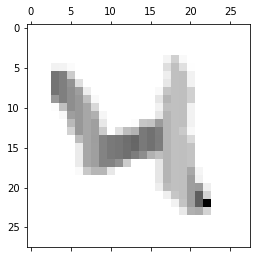

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [38]:
# input image dimensions
num_classes = 10 # 10 digits
img_rows, img_cols = 28, 28 # number of pixels 

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Scales data between 0 and 1
X_train = tf.keras.utils.normalize(X_train, axis=1)  
X_test = tf.keras.utils.normalize(X_test, axis=1)  

print('an example of a data point with label', y_train[20])
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

# reshape data, depending on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Define the Neural Network

We can now move on to construct our deep Neural Network. 
We implement a function to create our Сonvolutional Neural Network model.

In order for our NN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. The input is our 28 x 28 image and the output is a 10 x 1 vector representing the class of digit.

The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories, which is 10.

For now we use simple parameters. But we are going to tune them to get better accuracy.

In [59]:
def create_CNN(optimizer='adam',loss='binary_crossentropy', activation='relu', 
               conv_layers=2, dense_layers=2, filters=100, units = 100, dropout=False):
    
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=(5, 5),
                     activation=activation,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    if conv_layers>1:
        model.add(Conv2D(filters, (5, 5), activation=activation))
        if (dropout):
            model.add(Dropout(0.5))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    if dense_layers>1:
        model.add(Dense(units, activation=activation))
        if (dropout):
            model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation=tf.nn.softmax)) 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

In [47]:
def plot_accuracy_loss(model):
    history = model.history
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # plot accuracy per epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.set_title('Model Accuracy')  
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.yaxis.set_label_text('model accuracy')
    ax1.xaxis.set_label_text('epoch')
    ax1.legend(['train', 'test'], loc='best')

    # plot loss per epochs
    ax2.set_title('Model Loss')  
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.yaxis.set_label_text('model loss')
    ax2.xaxis.set_label_text('epoch')
    ax2.legend(['train', 'test'], loc='best')
    plt.show()

Test loss: 0.08705292773470283
Test accuracy: 0.9761


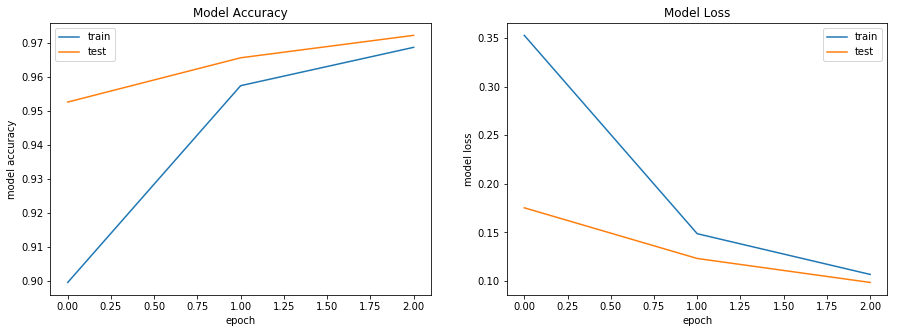

In [48]:
model_CNN_init=create_CNN(optimizer='adam',loss='categorical_crossentropy', activation='relu', 
               conv_layers=1, dense_layers=1, filters=20, units = 20)

model_CNN_init.fit(X_train, Y_train,
      batch_size=32,
      epochs=3,
      verbose=0,
      validation_split=0.2)
    
plot_accuracy_loss(model_CNN_init)

Our initial accuracy on validation data is 0.9761.
Next step is to make it higher.

# Train the model

Firstly, we need to define the lists of allowed optional parameters for Bach Size, number of Epochs, Optimization methods, activation functions, hidden units, hidden layers and loss functions. 

We train our NN in minibatches and shuffle the training data because it improves stability of the model. 
Also we train over smal number of training epochs, since large number increase computational time.

In [66]:
# list of allowed optional arguments
optimizer_list = ['SGD', 'Adam', 'RMSProp']
num_epochs = [2,4,10,20]
batch_size_list = [16,32,64,128]
conv_layers = [1,2]
filters = [20,50,100]
dense_layers = [1,2]
units = [50,100,300]
loss = ['sparse_categorical_crossentropy','categorical_crossentropy', 'binary_crossentropy']
activation_list = ['relu', 'tanh', 'sigmoid', tf.nn.leaky_relu]

In [52]:
def plot(leg):
    
    ax1.set_title('Accuracy on validation data')
    ax1.yaxis.set_label_text('model accuracy')
    ax1.xaxis.set_label_text('number of epoch')
    ax1.legend(leg, loc='best')

    ax2.set_title('Loss on validation data')    
    ax2.yaxis.set_label_text('model loss')
    ax2.xaxis.set_label_text('number of epoch')
    ax2.legend(leg, loc='best')
    plt.show()
    
batch_size = 32
epochs = 3

# Manual Search

### Loss function

For the regression task the commonly used loss function is mean squared error.

For classification task it is categorical cross entropy: 
$$-\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$$
and binary cross entropy:
$$L(\hat{y},y)=-\frac{1}{N}\sum_{c=1}^{M}[y_{i}log\hat{y}_{i}+(1-y_{i})log(1-\hat{y}_{i})]$$


Loss function: sparse_categorical_crossentropy, Accuracy: 0.9742, Error: 0.0854
Loss function: categorical_crossentropy, Accuracy: 0.9732, Error: 0.0931
Loss function: binary_crossentropy, Accuracy: 0.9953, Error: 0.0150


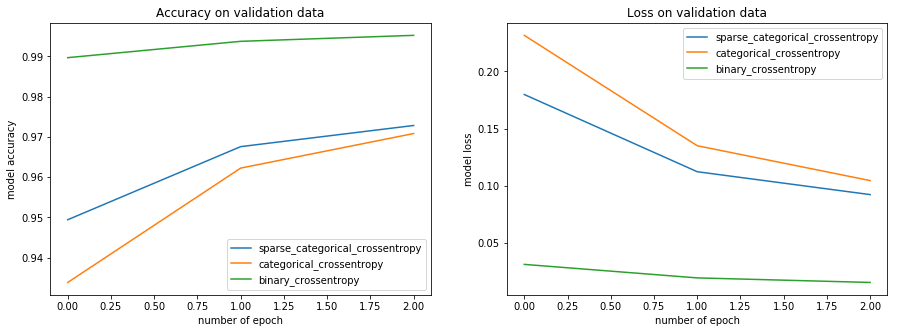

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for l in loss:
    if l == 'sparse_categorical_crossentropy':
        Y_train = y_train
        Y_test = y_test
    else:
        Y_train = keras.utils.to_categorical(y_train, num_classes)
        Y_test = keras.utils.to_categorical(y_test, num_classes)
        
    model_CNN=create_CNN(loss = l)
    
    model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)

    ax1.plot(model_CNN.history.history['val_acc'], label=l)  
    ax2.plot(model_CNN.history.history['val_loss'], label=l)
    val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)
    
    print(f'Loss function: {l}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(loss)

From the plot above we can easily see that binary_crossentropy had the best accuracy.

### The number of Hidden Layers and Hidden Units

The more layers and hidden units in a model, the more capacity it has. But it is not always good.
This two parameters depends on the data size.
A high capacity often means overfitting of a model. Rule of thumb is that if a smaller model performs better than a larger one on the test set, then the larger one has too much capacity for the training data.
We will try 1 or 2 convolutional layers with 20,50 and 100 filters.

#### Convolutional layers and filters

Convolutional layers: 1, Filters: 20, Accuracy: 0.9946, Error: 0.0165
Convolutional layers: 1, Filters: 50, Accuracy: 0.9946, Error: 0.0164
Convolutional layers: 1, Filters: 100, Accuracy: 0.9952, Error: 0.0150
Convolutional layers: 2, Filters: 20, Accuracy: 0.9954, Error: 0.0136
Convolutional layers: 2, Filters: 50, Accuracy: 0.9975, Error: 0.0073
Convolutional layers: 2, Filters: 100, Accuracy: 0.9976, Error: 0.0071


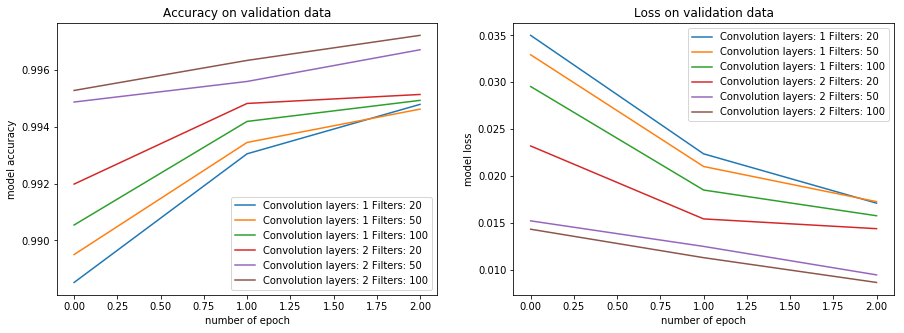

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
leg_c_f = []
for c in conv_layers:
    for fil in filters:
        leg_c_f.append('Convolution layers: '+ str(c) +' Filters: '+ str(fil))
        model_CNN=create_CNN(conv_layers = c, filters = fil)

        model_CNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.2)

        ax1.plot(model_CNN.history.history['val_acc'])  
        ax2.plot(model_CNN.history.history['val_loss'])
        val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)

        print(f'Convolutional layers: {c}, Filters: {fil}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(leg_c_f)

#### Dense layers and units

Dense layers: 1, Units: 50, Accuracy: 0.9974, Error: 0.0076
Dense layers: 1, Units: 100, Accuracy: 0.9976, Error: 0.0071
Dense layers: 1, Units: 300, Accuracy: 0.9977, Error: 0.0067
Dense layers: 2, Units: 50, Accuracy: 0.9973, Error: 0.0079
Dense layers: 2, Units: 100, Accuracy: 0.9976, Error: 0.0067
Dense layers: 2, Units: 300, Accuracy: 0.9972, Error: 0.0081


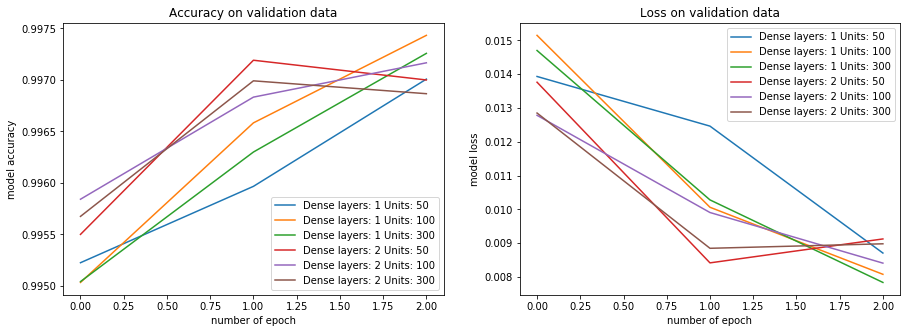

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
leg_d_u = []
for d in dense_layers:
    for u in units:
        leg_d_u.append('Dense layers: '+ str(d) +' Units: '+ str(u))
        model_CNN=create_CNN(dense_layers = d, units = u)

        model_CNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_split=0.2)

        ax1.plot(model_CNN.history.history['val_acc'])  
        ax2.plot(model_CNN.history.history['val_loss'])
        val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)

        print(f'Dense layers: {d}, Units: {u}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(leg_d_u)

### Activation function

The popular activation functions are:

$1)\textbf{reLU} $
$$f(x)=max(0,x)$$
$2)\textbf{sigmoid} $
$$t=\sum_{i=1}^{n}w_{i}x_{i}$$
$$s(t)=1/(1+e^{-t})$$
$3)\textbf{tanh}$
$$f(z)=\frac{(e^{z}-e^{-z})}{(e^{z}+e^{-z})}$$
$4)\textbf{leakyReLU}$


\begin{equation}
  f(net)=\begin{cases}
    net, & \text{if $net>=0$}.\\
    \alpha*net, & \text{$otherwise$}
  \end{cases}
\end{equation}

Often ReLU/LeakyReLU do well job. Sigmoid/tanh works for shallow networks.

Activation function: relu, Accuracy: 0.9975, Error: 0.0074
Activation function: tanh, Accuracy: 0.9950, Error: 0.0138
Activation function: sigmoid, Accuracy: 0.9948, Error: 0.0147
Activation function: <function leaky_relu at 0x7f5e7d322ea0>, Accuracy: 0.9976, Error: 0.0066


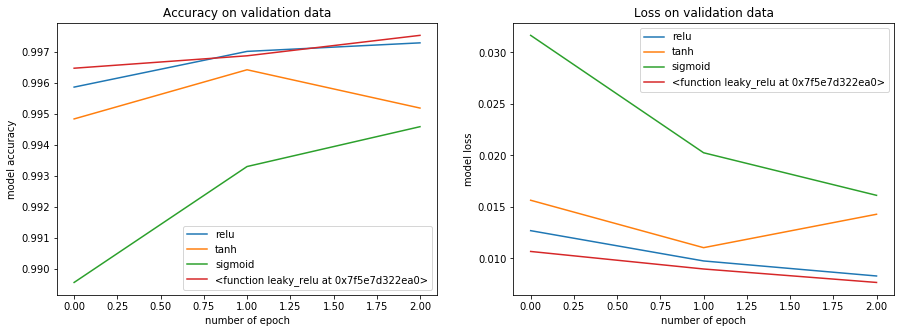

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for a in activation_list:
        
    model_CNN=create_CNN(activation = a)
    
    model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)

    ax1.plot(model_CNN.history.history['val_acc'], label=a)  
    ax2.plot(model_CNN.history.history['val_loss'], label=a)
    val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)
    
    print(f'Activation function: {a}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(activation_list)

The ReLU function showed the best accuracy.

### Optimizer

Optimizer updates weights of every layer after every iteration. 
Popular choices are SGD, RMSProp and Adam. 
SGD works well for shallow networks but cannot escape saddle points and local minima.
AdaDelta/AdaGrad uses for sparse data.
Adam is a general favorite and could be used to achieve faster convergence. 

Optimizer: SGD, Accuracy: 0.9743, Error: 0.0794
Optimizer: Adam, Accuracy: 0.9979, Error: 0.0067
Optimizer: RMSProp, Accuracy: 0.9978, Error: 0.0076


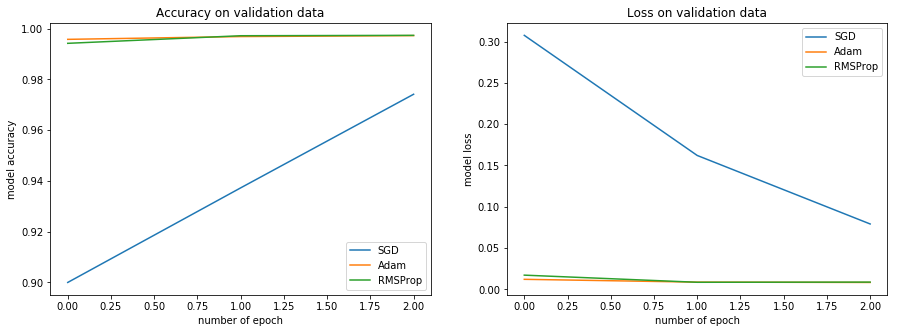

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for opt in optimizer_list:

    model_CNN=create_CNN(optimizer=opt)
    
    model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_split=0.2)

    ax1.plot(model_CNN.history.history['val_acc'], label=opt)  
    ax2.plot(model_CNN.history.history['val_loss'], label=opt)
    val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)
    
    print(f'Optimizer: {opt}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(optimizer_list)

### Batch size / number of epochs

Batch size is a number of patterns shown to the network before the batch size is updated. 
If batch size is less, patterns would be less repeating and weights would be all over the place and convergence would become difficult. 
If batch size is high learning would become slow as only after many iterations will the batch size change. For better memory optimization it is recommend to try batch sizes in powers of 2.


The number of epochs is the number of times the entire training data is shown to the model.
High number of epochs may overfit the data and may have generalization problems on the test and validation set, also they could cause vanishing and exploding gradient problems. Lower number of epochs may limit the potential of the model. 

Batch_size: 16, Epochs: 2, Accuracy: 0.9976, Error: 0.0072
Batch_size: 16, Epochs: 4, Accuracy: 0.9980, Error: 0.0061
Batch_size: 16, Epochs: 10, Accuracy: 0.9978, Error: 0.0081
Batch_size: 16, Epochs: 20, Accuracy: 0.9981, Error: 0.0094
Batch_size: 32, Epochs: 2, Accuracy: 0.9969, Error: 0.0085
Batch_size: 32, Epochs: 4, Accuracy: 0.9979, Error: 0.0057
Batch_size: 32, Epochs: 10, Accuracy: 0.9981, Error: 0.0070
Batch_size: 32, Epochs: 20, Accuracy: 0.9984, Error: 0.0083
Batch_size: 64, Epochs: 2, Accuracy: 0.9968, Error: 0.0096
Batch_size: 64, Epochs: 4, Accuracy: 0.9978, Error: 0.0065
Batch_size: 64, Epochs: 10, Accuracy: 0.9977, Error: 0.0076
Batch_size: 64, Epochs: 20, Accuracy: 0.9983, Error: 0.0078
Batch_size: 128, Epochs: 2, Accuracy: 0.9955, Error: 0.0135
Batch_size: 128, Epochs: 4, Accuracy: 0.9975, Error: 0.0075
Batch_size: 128, Epochs: 10, Accuracy: 0.9983, Error: 0.0053
Batch_size: 128, Epochs: 20, Accuracy: 0.9982, Error: 0.0077


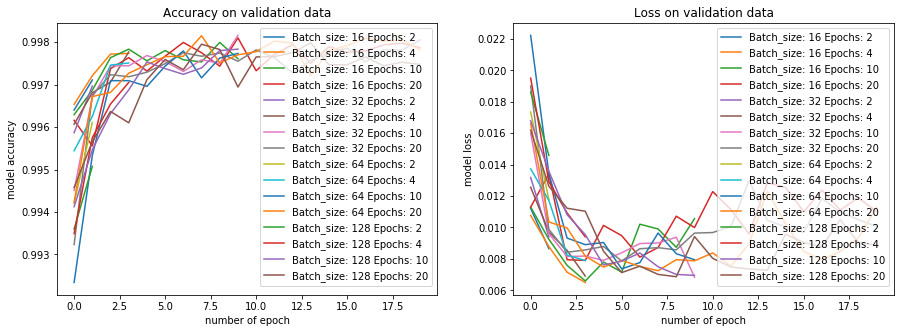

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
leg = []

for b in batch_size_list:
    for e in num_epochs:
        leg.append('Batch_size: '+ str(b) +' Epochs: '+ str(e))

        model_CNN=create_CNN()

        model_CNN.fit(X_train, Y_train,
              batch_size=b,
              epochs=e,
              verbose=0,
              validation_split=0.2)

        ax1.plot(model_CNN.history.history['val_acc'])  
        ax2.plot(model_CNN.history.history['val_loss'])
        val_loss, val_acc = model_CNN.evaluate(X_test, Y_test, verbose=0)

        print(f'Batch_size: {b}, Epochs: {e}, Accuracy: {val_acc:.4f}, Error: {val_loss:.4f}')  
    
plot(leg)

# Model Performance

After getting a new set of hyperparameters by manual search, we again evaluate the model.

Test loss: 0.007124705396589252
Test accuracy: 0.99798999710083


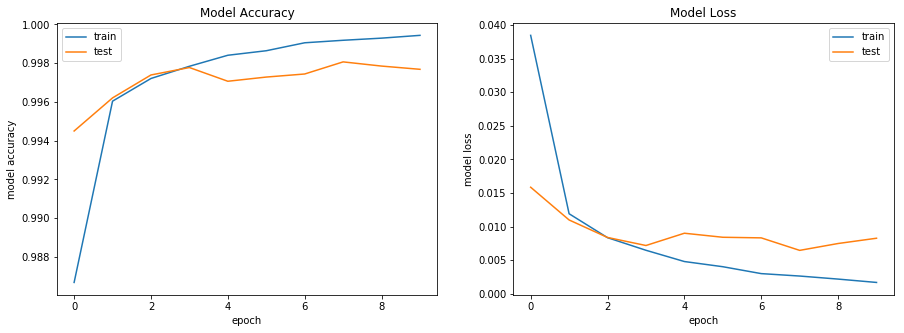

In [63]:
model_CNN_final=create_CNN(optimizer='adam',loss='binary_crossentropy', activation='relu', 
               conv_layers=2, dense_layers=2, filters=100, units = 100)

model_CNN_final.fit(X_train, Y_train,
      batch_size=32,
      epochs=10,
      verbose=0,
      validation_split=0.2)

plot_accuracy_loss(model_CNN_final)

Now we can see that our accuracy has increased from 0.9761 to 0.9979.

### Dropout

Dropout layer is like a hyperparameter which could act as a regularizer to help us find the optimum bias-variance spot. It removes certain connections every iteration therefore the hidden units cannot depend a lot on any particular feature. The values it can take can be anywhere between 0a nd 1 and it is based on how much is the model overfitting.

Test loss: 0.004532245754551695
Test accuracy: 0.998439997291565


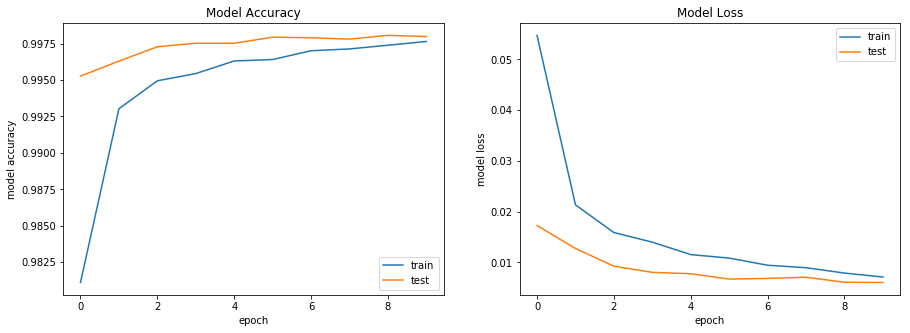

In [64]:
model_CNN_final_drop=create_CNN(optimizer='adam',loss='binary_crossentropy', activation='relu', 
               conv_layers=2, dense_layers=2, filters=100, units = 100, dropout=True)

model_CNN_final_drop.fit(X_train, Y_train,
      batch_size=32,
      epochs=10,
      verbose=0,
      validation_split=0.2)

plot_accuracy_loss(model_CNN_final_drop)

Total accuracy has increased a little bit more: 0.9984

# Grid search

Now we are going to solve our problem another way by using Grid search.

Grid search is exhaustive search over specified parameter values for an estimator.

Firstly, we will train model for all possible parameter combinations and select the best one.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. 

In [68]:
model_gridsearch = KerasClassifier(build_fn=create_CNN, verbose=1)

param_grid = dict(conv_layers = conv_layers,
dense_layers = dense_layers, filters =filters, loss=loss, optimizer=optimizer_list, units = units,
batch_size = batch_size_list, activation=activation_list, epochs=num_epochs)

grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=2)
grid_result = grid.fit(X_train,Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997117 using {'conv_layers': 2, 'dense_layers': 2, 'filters': 100, 'loss': 'binary_crossentropy', 'optimizer': 'Adam', 'units': 100, 'batch_size': 32, 'activation': 'relu', 'epochs': '10'}

# Conclusion

Although Grid search is guaranteed to find the optimal combination of hyperparameters, it is very computationally expensive.

Manual search also hs two sides of the medal. It can can give the insight into how the algorithm works and get a good accuracy. But, on the other hand it is not reproducible, and has no guarantee of success, particularly in higher dimension spaces.

With all mentioned above we can firstly use manual search to minimize the number of possible values that each parameter can take, and then perform a grid search over these remaining values.